## Applying Deep Learning Techniques to Predict Simulium Damnosum Habitat Locations
<hr>
### Data
- 0.6m panchromatic and 2.4 8-band satellite data from worldview-2
- ~30 data points of river locations and Simulium Damnosum larvae counts

### Approach
Few labeled data and an abundance of unlabeled data makes this problem suitable for a semi-supervised approach. We wil first build a variational auto encoder to extract features that we can then use a supervised approach using the labels.

### 1: Image Extraction
- Extract images of size 32x32?

In [75]:
 """
Read satellite data
"""

import gdal
import osr
import numpy as np
from scipy.misc import toimage

IMG_SIZE = 128

sat_file = '../data/sat/06/06m.tif'

tif = gdal.Open(sat_file)
width = tif.RasterXSize
height = tif.RasterYSize

geo_transform = tif.GetGeoTransform()

img_space = osr.SpatialReference()
img_space.ImportFromWkt(tif.GetProjectionRef())

geo_space = osr.SpatialReference()
geo_space.SetWellKnownGeogCS('WGS84')

# Used to convert from geocoordinate space to image space
transform = osr.CoordinateTransformation(geo_space, img_space)

"""
build array of image start points and randomize to decorrelate
"""

points = np.mgrid[300:width - IMG_SIZE:IMG_SIZE, 0:height - IMG_SIZE:IMG_SIZE].reshape(2,-1).T.astype(np.double)
np.random.shuffle(points)
"""
extract images
"""
import os

def save(points, directory):
    dimensions = [IMG_SIZE, IMG_SIZE]
    dir1 = -1
    dir2 = -1
    cur_dir = "{0}/{1}/{2}".format(directory, dir1, dir2)
    for i, point in enumerate(points):
        pixels = np.zeros((dimensions[1], dimensions[0], 3), dtype = np.uint8)
        for band in range(1, 4):
            raster = tif.GetRasterBand(band)
            img_data = raster.ReadAsArray(point[0], point[1], dimensions[0], dimensions[1])
            pixels[:, :, band - 1] = img_data

        img = toimage(pixels)
        if i % 100 == 0:
            dir2 = i
            if i % 10000 == 0:
                dir1 = i
            cur_dir = "{0}/{1}/{2}".format(directory, dir1, dir2)
            if not os.path.exists(cur_dir):
                os.makedirs(cur_dir)
        img.save("{0}/{1}.png".format(cur_dir, i))
        if i % 1000 == 0:
            print("{0}/{1}".format(i, points.shape[0]))

n = points.shape[0]
val_divide = int(n * 0.6)
test_divide = int(n * 0.8)

save(points[:val_divide], 'data/imgs/train')
save(points[val_divide:test_divide], 'data/imgs/val')
save(points[test_divide:n], 'data/imgs/test')

0/9525
1000/9525
2000/9525
3000/9525
4000/9525
5000/9525
6000/9525
7000/9525
8000/9525
9000/9525
0/3175
1000/3175
2000/3175
3000/3175
0/3175
1000/3175
2000/3175
3000/3175


### 2: Image Preprocessing and Generation

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

IMG_SIZE = 128

datagen = ImageDataGenerator(
    channel_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True
)

def XX(gen):
    for x in gen:
        yield x, x
        
train_generator = XX(datagen.flow_from_directory(
        'data/imgs/train',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        class_mode=None))

val_generator = XX(datagen.flow_from_directory(
        'data/imgs/val',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        class_mode=None))

test_generator = XX(datagen.flow_from_directory(
        'data/imgs/test',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=1,
        class_mode=None))

Using TensorFlow backend.


Found 9525 images belonging to 1 classes.
Found 3175 images belonging to 1 classes.
Found 3175 images belonging to 1 classes.


### 3: Build Auto Encoder

In [1]:
#Baseline

from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, add
from keras.models import Model

encoder_input_0 = Input(shape = (None, None, 3))
x = Conv2D(16, (3, 3), padding = 'same', activation = 'relu', strides = (2, 2))(encoder_input_0)
x = Conv2D(32, (3, 3), padding = 'same', activation = 'relu', strides = (2, 2))(x)
x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', strides = (2, 2))(x)
x = Conv2D(128, (3, 3), padding = 'same', activation = 'relu', strides = (2, 2))(x)
encoder_output_0 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', strides = (2, 2))(x)
encoder_input_1 = Input(shape = (None, None, 256))
encoder_output_1 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', strides = (2, 2))(encoder_input_1)
encoder_input_2 = Input(shape = (None, None, 256))
encoder_output_2 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', strides = (2, 2))(encoder_input_2)

encoder_link_0 = Model(encoder_input_0, encoder_output_0)
encoder_link_1 = Model(encoder_input_1, encoder_output_1)
encoder_link_2 = Model(encoder_input_2, encoder_output_2)

encoder_model_input = Input(shape = (None, None, 3))
encoder_model_output_0 = encoder_link_0(encoder_model_input)
encoder_model_output_1 = encoder_link_1(encoder_model_output_0)
encoder_model_output_2 = encoder_link_2(encoder_model_output_1)
encoder_model_0 = Model(encoder_model_input, encoder_model_output_0)
encoder_model_1 = Model(encoder_model_input, encoder_model_output_1)
encoder_model_2 = Model(encoder_model_input, encoder_model_output_2)
encoder_model_2.summary()

decoder_input_2 = Input(shape = (None, None, 256))
decoder_output_2 = Conv2DTranspose(256, (3, 3), padding = 'same', activation = 'relu', strides = (2, 2))(decoder_input_2)
decoder_input_1 = Input(shape = (None, None, 256))
decoder_output_1 = Conv2DTranspose(256, (3, 3), padding = 'same', activation = 'relu', strides = (2, 2))(decoder_input_1)
decoder_input_0 = Input(shape = (None, None, 256))
x = Conv2DTranspose(128, (3, 3), padding = 'same', activation = 'relu', strides = (2, 2))(decoder_input_0)
x = Conv2DTranspose(64, (3, 3), padding = 'same', activation = 'relu', strides = (2, 2))(x)
x = Conv2DTranspose(32, (3, 3), padding = 'same', activation = 'relu', strides = (2, 2))(x)
x = Conv2DTranspose(16, (3, 3), padding = 'same', activation = 'relu', strides = (2, 2))(x)
decoder_output_0 = Conv2DTranspose(3, (3, 3), padding = 'same', activation = 'relu', strides = (2, 2))(x)

decoder_link_2 = Model(decoder_input_2, decoder_output_2)
decoder_link_1 = Model(decoder_input_1, decoder_output_1)
decoder_link_0 = Model(decoder_input_0, decoder_output_0)

decoder_model_input_0 = Input(shape = (None, None, 256))
decoder_model_output_0 = decoder_link_0(decoder_model_input_0)
decoder_model_0 = Model(decoder_model_input_0, decoder_model_output_0)

decoder_model_input_1 = Input(shape = (None, None, 256))
decoder_model_output_1 = decoder_link_1(decoder_model_input_1)
decoder_model_output_0 = decoder_link_0(decoder_model_output_1)
decoder_model_1 = Model(decoder_model_input_1, decoder_model_output_0)

decoder_model_input_2 = Input(shape = (None, None, 256))
decoder_model_output_2 = decoder_link_2(decoder_model_input_2)
decoder_model_output_1 = decoder_link_1(decoder_model_output_2)
decoder_model_output_0 = decoder_link_0(decoder_model_output_1)
decoder_model_2 = Model(decoder_model_input_2, decoder_model_output_0)

input_img = Input(shape = (None, None, 3))
encoder = encoder_model_2(input_img)
decoder = decoder_model_2(encoder)
autoencoder = Model(input_img, decoder)
autoencoder.compile(optimizer='adadelta', loss='mse')
autoencoder.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
model_1 (Model)              (None, None, None, 256)   392608    
_________________________________________________________________
model_2 (Model)              (None, None, None, 256)   590080    
_________________________________________________________________
model_3 (Model)              (None, None, None, 256)   590080    
Total params: 1,572,768
Trainable params: 1,572,768
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________


In [56]:
encoder_model_1.save_weights('tmp/32/encoder_1.hdf5')
decoder_model_1.save_weights('tmp/32/decoder_1.hdf5')

In [65]:
encoder_model_1.load_weights('tmp/32/encoder_1.hdf5')
decoder_model_1.load_weights('tmp/32/decoder_1.hdf5')

In [2]:
autoencoder.load_weights('tmp/32/weights.hdf5')

In [ ]:
autoencoder.save('models/autoencoder.h5')
encoder.save('models/encoder.h5')

### 4: Train

In [67]:
from keras.callbacks import ModelCheckpoint
import os
weights_dir = 'tmp/32/'
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

checkpointer = ModelCheckpoint(filepath = '{0}/weights.hdf5'.format(weights_dir), verbose = 1, save_best_only = False)
autoencoder.fit_generator(
        train_generator,
        steps_per_epoch = 1000,
        epochs = 2000,
        validation_data = val_generator,
        validation_steps = 200,
        callbacks = [checkpointer])

Epoch 1/2000
1000/1000 [==============================] - 78s - loss: 1259.7999 - val_loss: 1237.9254
Epoch 2/2000
1000/1000 [==============================] - 64s - loss: 1247.3938 - val_loss: 1215.5200
Epoch 3/2000
1000/1000 [==============================] - 61s - loss: 1230.2662 - val_loss: 1235.9490
Epoch 4/2000
1000/1000 [==============================] - 62s - loss: 1219.7384 - val_loss: 1214.6419
Epoch 5/2000
1000/1000 [==============================] - 63s - loss: 1208.7088 - val_loss: 1186.4321
Epoch 6/2000
1000/1000 [==============================] - 62s - loss: 1203.7849 - val_loss: 1190.3650
Epoch 7/2000
1000/1000 [==============================] - 64s - loss: 1198.9185 - val_loss: 1195.3141
Epoch 8/2000
1000/1000 [==============================] - 61s - loss: 1192.5047 - val_loss: 1188.7834
Epoch 9/2000
1000/1000 [==============================] - 61s - loss: 1185.6294 - val_loss: 1182.5574
Epoch 10/2000
1000/1000 [==============================] - 60s - loss: 1181.3728 -

1000/1000 [==============================] - 61s - loss: 1072.4663 - val_loss: 1087.5081
Epoch 75/2000
1000/1000 [==============================] - 61s - loss: 1072.1841 - val_loss: 1103.4067
Epoch 76/2000
1000/1000 [==============================] - 60s - loss: 1068.6925 - val_loss: 1083.9536
Epoch 77/2000
1000/1000 [==============================] - 60s - loss: 1070.5365 - val_loss: 1094.0481
Epoch 78/2000
1000/1000 [==============================] - 60s - loss: 1068.7780 - val_loss: 1086.3055
Epoch 79/2000
1000/1000 [==============================] - 60s - loss: 1067.2983 - val_loss: 1064.5012
Epoch 80/2000
1000/1000 [==============================] - 60s - loss: 1067.4320 - val_loss: 1093.0830
Epoch 81/2000
1000/1000 [==============================] - 60s - loss: 1066.1928 - val_loss: 1079.3855
Epoch 82/2000
1000/1000 [==============================] - 60s - loss: 1063.6765 - val_loss: 1082.3586
Epoch 83/2000
1000/1000 [==============================] - 60s - loss: 1064.4297 - val_

1000/1000 [==============================] - 60s - loss: 1028.9052 - val_loss: 1033.6835
Epoch 148/2000
1000/1000 [==============================] - 60s - loss: 1024.8246 - val_loss: 1032.8979
Epoch 149/2000
1000/1000 [==============================] - 60s - loss: 1025.2398 - val_loss: 1032.9663
Epoch 150/2000
1000/1000 [==============================] - 60s - loss: 1025.8756 - val_loss: 1089.4685
Epoch 151/2000
1000/1000 [==============================] - 60s - loss: 1024.1558 - val_loss: 1029.8876
Epoch 152/2000
1000/1000 [==============================] - 60s - loss: 1023.9279 - val_loss: 1039.9645
Epoch 153/2000
1000/1000 [==============================] - 60s - loss: 1022.8897 - val_loss: 1053.4695
Epoch 154/2000
1000/1000 [==============================] - 60s - loss: 1024.3041 - val_loss: 1024.1975
Epoch 155/2000
1000/1000 [==============================] - 60s - loss: 1021.0149 - val_loss: 1030.0753
Epoch 156/2000
1000/1000 [==============================] - 60s - loss: 1022.70

1000/1000 [==============================] - 60s - loss: 1005.5251 - val_loss: 1017.3343
Epoch 221/2000
1000/1000 [==============================] - 60s - loss: 1002.7730 - val_loss: 1018.8512
Epoch 222/2000
1000/1000 [==============================] - 60s - loss: 1004.3145 - val_loss: 1019.6857
Epoch 223/2000
1000/1000 [==============================] - 60s - loss: 1004.8293 - val_loss: 1010.2421
Epoch 224/2000
1000/1000 [==============================] - 60s - loss: 1002.0897 - val_loss: 1010.7236
Epoch 225/2000
1000/1000 [==============================] - 60s - loss: 1003.5764 - val_loss: 1042.9062
Epoch 226/2000
1000/1000 [==============================] - 60s - loss: 1002.1184 - val_loss: 1021.8634
Epoch 227/2000
1000/1000 [==============================] - 60s - loss: 1002.3169 - val_loss: 1020.5161
Epoch 228/2000
1000/1000 [==============================] - 60s - loss: 1002.6048 - val_loss: 1018.7175
Epoch 229/2000
1000/1000 [==============================] - 60s - loss: 1002.92

1000/1000 [==============================] - 60s - loss: 991.2112 - val_loss: 1014.4156
Epoch 294/2000
1000/1000 [==============================] - 60s - loss: 992.3477 - val_loss: 1015.0576
Epoch 295/2000
1000/1000 [==============================] - 60s - loss: 990.5697 - val_loss: 1008.9950
Epoch 296/2000
1000/1000 [==============================] - 60s - loss: 989.8194 - val_loss: 1006.5173
Epoch 297/2000
1000/1000 [==============================] - 60s - loss: 992.3908 - val_loss: 1013.0225
Epoch 298/2000
1000/1000 [==============================] - 60s - loss: 991.5491 - val_loss: 1007.9576
Epoch 299/2000
1000/1000 [==============================] - 60s - loss: 990.1170 - val_loss: 1019.2589
Epoch 300/2000
1000/1000 [==============================] - 60s - loss: 990.5789 - val_loss: 1010.9340
Epoch 301/2000
1000/1000 [==============================] - 60s - loss: 989.3897 - val_loss: 1014.5973
Epoch 302/2000
1000/1000 [==============================] - 60s - loss: 990.0027 - val_l

1000/1000 [==============================] - 60s - loss: 984.2652 - val_loss: 1015.6472
Epoch 367/2000
1000/1000 [==============================] - 60s - loss: 983.1327 - val_loss: 1014.1705
Epoch 368/2000
1000/1000 [==============================] - 60s - loss: 982.3406 - val_loss: 1019.2003
Epoch 369/2000
1000/1000 [==============================] - 60s - loss: 982.2533 - val_loss: 1012.3288
Epoch 370/2000
1000/1000 [==============================] - 60s - loss: 982.7737 - val_loss: 999.9462
Epoch 371/2000
1000/1000 [==============================] - 60s - loss: 983.4761 - val_loss: 1020.9730
Epoch 372/2000
1000/1000 [==============================] - 60s - loss: 981.5500 - val_loss: 1004.5521
Epoch 373/2000
1000/1000 [==============================] - 60s - loss: 982.4728 - val_loss: 1009.3129
Epoch 374/2000
1000/1000 [==============================] - 60s - loss: 983.1670 - val_loss: 1016.2464
Epoch 375/2000
1000/1000 [==============================] - 60s - loss: 982.9376 - val_lo

1000/1000 [==============================] - 60s - loss: 981.8353 - val_loss: 1035.8511
Epoch 404/2000
1000/1000 [==============================] - 60s - loss: 980.3373 - val_loss: 1002.3507
Epoch 405/2000
1000/1000 [==============================] - 60s - loss: 980.6037 - val_loss: 1011.9595
Epoch 406/2000
1000/1000 [==============================] - 60s - loss: 980.0140 - val_loss: 1009.1567
Epoch 407/2000
1000/1000 [==============================] - 60s - loss: 978.7925 - val_loss: 1010.5336
Epoch 408/2000
1000/1000 [==============================] - 60s - loss: 979.6210 - val_loss: 1003.2183
Epoch 409/2000
1000/1000 [==============================] - 60s - loss: 979.9764 - val_loss: 1006.5552
Epoch 410/2000
1000/1000 [==============================] - 60s - loss: 978.7263 - val_loss: 1005.0518
Epoch 411/2000
1000/1000 [==============================] - 60s - loss: 978.1229 - val_loss: 1023.9251
Epoch 412/2000
1000/1000 [==============================] - 60s - loss: 980.7604 - val_l

1000/1000 [==============================] - 60s - loss: 978.0432 - val_loss: 1004.1605
Epoch 441/2000
1000/1000 [==============================] - 60s - loss: 976.4390 - val_loss: 1022.4959
Epoch 442/2000
1000/1000 [==============================] - 60s - loss: 976.4723 - val_loss: 1024.5559
Epoch 443/2000
1000/1000 [==============================] - 60s - loss: 977.5473 - val_loss: 1015.3070
Epoch 444/2000
1000/1000 [==============================] - 60s - loss: 977.4171 - val_loss: 1005.1230
Epoch 445/2000
1000/1000 [==============================] - 60s - loss: 976.6908 - val_loss: 1008.3484
Epoch 446/2000
1000/1000 [==============================] - 60s - loss: 975.7227 - val_loss: 1007.8011
Epoch 447/2000
1000/1000 [==============================] - 60s - loss: 977.3078 - val_loss: 1005.9826
Epoch 448/2000
1000/1000 [==============================] - 60s - loss: 975.6458 - val_loss: 1001.9492
Epoch 449/2000
1000/1000 [==============================] - 60s - loss: 976.7520 - val_l

1000/1000 [==============================] - 68s - loss: 972.4237 - val_loss: 1049.3510
Epoch 514/2000
1000/1000 [==============================] - 60s - loss: 971.3137 - val_loss: 1006.5777
Epoch 515/2000
1000/1000 [==============================] - 60s - loss: 973.0430 - val_loss: 1009.2856
Epoch 516/2000
1000/1000 [==============================] - 60s - loss: 972.3051 - val_loss: 1001.7923
Epoch 517/2000
1000/1000 [==============================] - 60s - loss: 973.3106 - val_loss: 1024.3675
Epoch 518/2000
1000/1000 [==============================] - 60s - loss: 970.6363 - val_loss: 1006.7840
Epoch 519/2000
1000/1000 [==============================] - 60s - loss: 972.9505 - val_loss: 1024.6655
Epoch 520/2000
1000/1000 [==============================] - 60s - loss: 972.4506 - val_loss: 1013.0470
Epoch 521/2000
1000/1000 [==============================] - 60s - loss: 971.3802 - val_loss: 1016.5710
Epoch 522/2000
1000/1000 [==============================] - 60s - loss: 972.9595 - val_l

1000/1000 [==============================] - 60s - loss: 971.6387 - val_loss: 1005.5909
Epoch 551/2000
1000/1000 [==============================] - 60s - loss: 970.1226 - val_loss: 1000.6627
Epoch 552/2000
1000/1000 [==============================] - 60s - loss: 969.5163 - val_loss: 1012.4984
Epoch 553/2000
1000/1000 [==============================] - 60s - loss: 971.5428 - val_loss: 999.8600
Epoch 554/2000
1000/1000 [==============================] - 60s - loss: 969.6679 - val_loss: 1005.1454
Epoch 555/2000
1000/1000 [==============================] - 60s - loss: 970.7096 - val_loss: 1007.9081
Epoch 556/2000
1000/1000 [==============================] - 60s - loss: 970.0017 - val_loss: 1010.1498
Epoch 557/2000
1000/1000 [==============================] - 60s - loss: 970.3807 - val_loss: 1031.1966
Epoch 558/2000
1000/1000 [==============================] - 60s - loss: 968.6645 - val_loss: 1003.6582
Epoch 559/2000
1000/1000 [==============================] - 60s - loss: 970.8082 - val_lo

1000/1000 [==============================] - 60s - loss: 966.7553 - val_loss: 1000.1244
Epoch 624/2000
1000/1000 [==============================] - 60s - loss: 967.8596 - val_loss: 1007.4995
Epoch 625/2000
1000/1000 [==============================] - 60s - loss: 966.8896 - val_loss: 998.0558
Epoch 626/2000
1000/1000 [==============================] - 60s - loss: 967.3310 - val_loss: 1011.0146
Epoch 627/2000
1000/1000 [==============================] - 60s - loss: 967.4965 - val_loss: 1002.9408
Epoch 628/2000
1000/1000 [==============================] - 60s - loss: 967.1558 - val_loss: 1001.9069
Epoch 629/2000
1000/1000 [==============================] - 60s - loss: 966.3795 - val_loss: 1008.7953
Epoch 630/2000
1000/1000 [==============================] - 60s - loss: 966.7013 - val_loss: 1011.5744
Epoch 631/2000
1000/1000 [==============================] - 60s - loss: 967.2948 - val_loss: 1013.2215
Epoch 632/2000
1000/1000 [==============================] - 60s - loss: 966.1042 - val_lo

1000/1000 [==============================] - 60s - loss: 964.4738 - val_loss: 1015.5178
Epoch 661/2000
1000/1000 [==============================] - 60s - loss: 963.8174 - val_loss: 1011.5642
Epoch 662/2000
1000/1000 [==============================] - 60s - loss: 966.0504 - val_loss: 1026.3199
Epoch 663/2000
1000/1000 [==============================] - 60s - loss: 964.6734 - val_loss: 1035.4767
Epoch 664/2000
1000/1000 [==============================] - 60s - loss: 966.7089 - val_loss: 1014.4641
Epoch 665/2000
1000/1000 [==============================] - 60s - loss: 965.2736 - val_loss: 1015.0520
Epoch 666/2000
1000/1000 [==============================] - 60s - loss: 964.6263 - val_loss: 1008.1127
Epoch 667/2000
1000/1000 [==============================] - 60s - loss: 967.3223 - val_loss: 1002.1363
Epoch 668/2000
1000/1000 [==============================] - 60s - loss: 963.6678 - val_loss: 1012.3453
Epoch 669/2000
1000/1000 [==============================] - 60s - loss: 964.8028 - val_l

1000/1000 [==============================] - 60s - loss: 963.2086 - val_loss: 1008.8753
Epoch 734/2000
1000/1000 [==============================] - 60s - loss: 963.0268 - val_loss: 1007.5447
Epoch 735/2000
1000/1000 [==============================] - 60s - loss: 963.8732 - val_loss: 1013.8012
Epoch 736/2000
1000/1000 [==============================] - 60s - loss: 963.4799 - val_loss: 1011.1594
Epoch 737/2000
1000/1000 [==============================] - 60s - loss: 963.2515 - val_loss: 1019.2641
Epoch 738/2000
1000/1000 [==============================] - 60s - loss: 963.4135 - val_loss: 1014.4590
Epoch 739/2000
1000/1000 [==============================] - 60s - loss: 962.0484 - val_loss: 1026.7511
Epoch 740/2000
1000/1000 [==============================] - 60s - loss: 962.7757 - val_loss: 1007.7968
Epoch 741/2000
1000/1000 [==============================] - 60s - loss: 963.4182 - val_loss: 1008.6249
Epoch 742/2000
1000/1000 [==============================] - 60s - loss: 962.6189 - val_l

1000/1000 [==============================] - 60s - loss: 961.9250 - val_loss: 1005.6258
Epoch 807/2000
1000/1000 [==============================] - 60s - loss: 960.3501 - val_loss: 1015.5607
Epoch 808/2000
1000/1000 [==============================] - 60s - loss: 962.2098 - val_loss: 1002.5777
Epoch 809/2000
1000/1000 [==============================] - 60s - loss: 960.7591 - val_loss: 1009.8046
Epoch 810/2000
1000/1000 [==============================] - 60s - loss: 959.7041 - val_loss: 1004.9170
Epoch 811/2000
1000/1000 [==============================] - 60s - loss: 961.7810 - val_loss: 1006.6946
Epoch 812/2000
1000/1000 [==============================] - 60s - loss: 960.8098 - val_loss: 1013.0790
Epoch 813/2000
1000/1000 [==============================] - 60s - loss: 961.4981 - val_loss: 1006.5284
Epoch 814/2000
1000/1000 [==============================] - 60s - loss: 958.9300 - val_loss: 1002.3096
Epoch 815/2000
1000/1000 [==============================] - 60s - loss: 961.8171 - val_l

KeyboardInterrupt: 

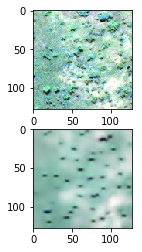

In [68]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

img = next(test_generator)[0]
decoded_img = autoencoder.predict(img)

#img = img.squeeze() * datagen.std + datagen.mean
#decoded_img = decoded_img.squeeze() * datagen.std + datagen.mean

plt.figure(1)
plt.subplot(211)
plt.imshow(img.squeeze().astype(np.uint8))
plt.subplot(212)
plt.imshow(decoded_img.squeeze().astype(np.uint8))

### 4: Extract Simulium Damnosum Data

In [69]:
import pandas as pd

data = pd.read_csv('../data/sat/06/simulium.csv')
print(data.head())

points = data[['Lat', 'Long']].values

   Object_ID    Long     Lat  Larvae
0          1  32.366  3.2985      18
1          2  32.361  3.3005      25
2          3  32.363  3.2990       0
3          4  32.359  3.3020       0
4          5  32.364  3.2987       0


In [70]:
import gdal
import osr
import numpy as np
from scipy.misc import toimage
import os

sat_file = '../data/sat/06/06m.tif'
tif = gdal.Open(sat_file)

IMG_SIZE = 128
dimensions = [IMG_SIZE, IMG_SIZE]

geo_transform = tif.GetGeoTransform()

img_space = osr.SpatialReference()
img_space.ImportFromWkt(tif.GetProjectionRef())

geo_space = osr.SpatialReference()
geo_space.SetWellKnownGeogCS('WGS84')

# Used to convert from geocoordinate space to image space
transform = osr.CoordinateTransformation(geo_space, img_space)

"""
Convert points to image space
"""

image_points = []
for point in points:
    coord = np.array(transform.TransformPoint(point[1], point[0]))
    coord[0] = int((coord[0] - geo_transform[0]) / geo_transform[1]) #x pixel
    coord[1] = int((coord[1] - geo_transform[3]) / geo_transform[5]) #y pixel
    
    image_points.append(np.array([coord[0], coord[1]], dtype = np.int))

imgs = []
for i, point in enumerate(image_points):
    top_left = point - (IMG_SIZE / 2)
    pixels = np.zeros((dimensions[1], dimensions[0], 3))
    for band in range(1, 4):
        raster = tif.GetRasterBand(band)
        img_data = raster.ReadAsArray(top_left[0], top_left[1], dimensions[0], dimensions[1])
        pixels[:, :, band - 1] = img_data
    
    imgs.append(np.array(pixels))
    if not os.path.exists('data/sites'):
        os.makedirs('data/sites')
imgs = np.array(imgs)

### 5: Regression

In [71]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_validate

x = encoder_model.predict(imgs, batch_size = 1)
x = x.reshape(20, 4096)
print(x.shape)
y = data['Larvae'].values

estimator = GaussianProcessRegressor()

results = pd.DataFrame(cross_validate(estimator, x, y, scoring = 'r2', cv = 5, return_train_score = True))
results = results.drop(['score_time', 'fit_time'], 1)
print(results)
results.to_html('results.html')

(20, 4096)
   test_score  train_score
0   -0.949666          1.0
1   -2.125786          1.0
2   -3.637947          1.0
3   -1.423529          1.0
4   -0.333333          1.0


(20, 128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


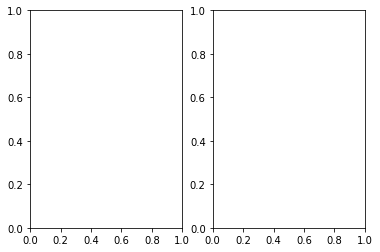

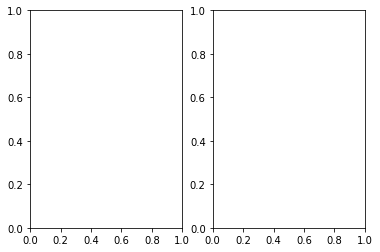

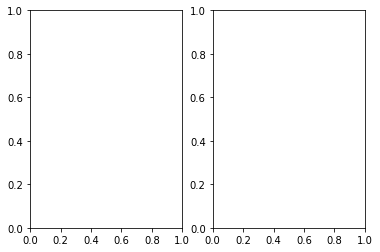

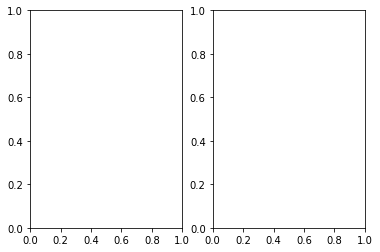

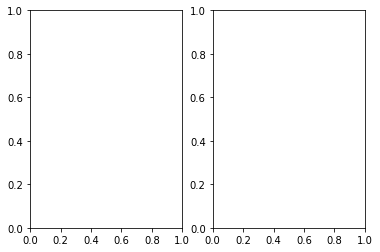

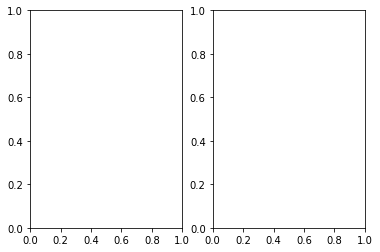

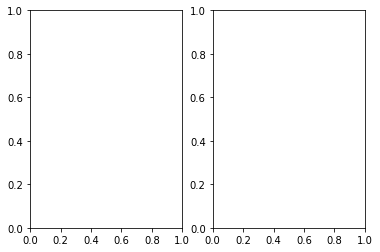

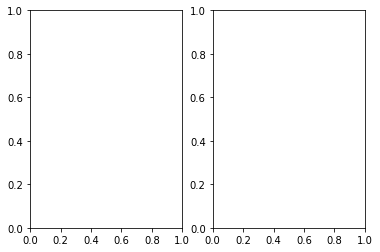

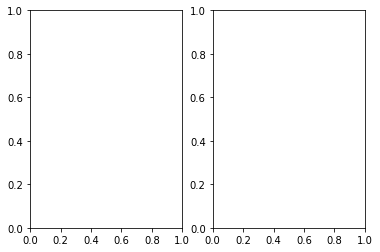

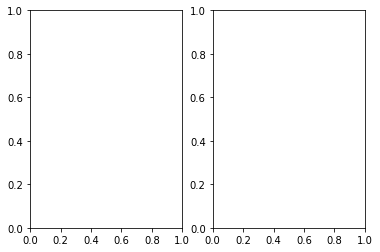

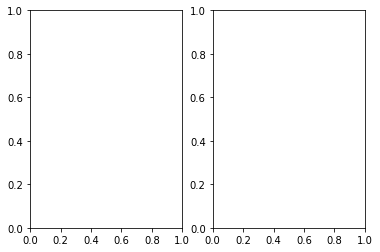

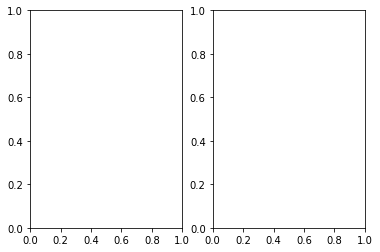

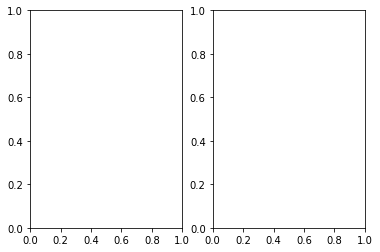

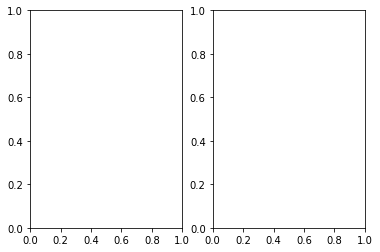

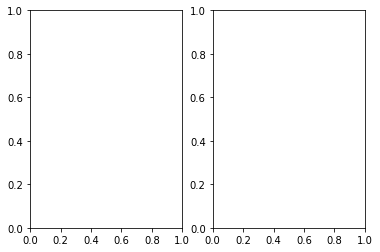

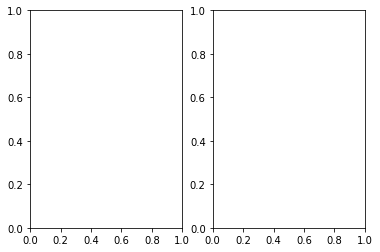

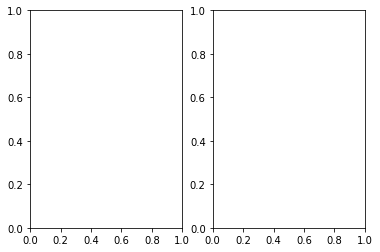

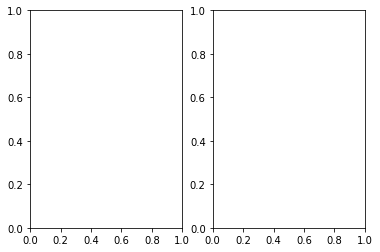

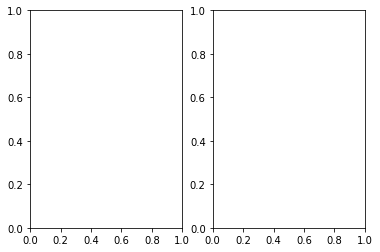

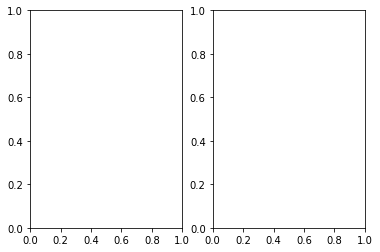

In [72]:
from scipy.misc import imsave
from matplotlib import pyplot as plt
import os
def concat(decoded):
    decoded_concat = np.zeros((128, 128, 3))
    for i in range(4):
        for j in range(4):
            k = j * 4 + i
            decoded_concat[j * 32:(j + 1) * 32, i * 32:(i + 1) * 32] = decoded[k]
    return decoded_concat

if not os.path.exists('gen'):
    os.makedirs('gen')
    
print(imgs.shape)

for i in range(imgs.shape[0]):
    encoded = encoder_model.predict(np.expand_dims(imgs[i], axis = 0), batch_size = 1)
    decoded = decoder_model.predict(encoded, batch_size = 1).squeeze()
    print(decoded.shape)
    plt.figure(i)
    plt.subplot(1, 2, 1)
    imsave('gen/{0}_original.png'.format(i), imgs[i])
    plt.subplot(1, 2, 2)
    imsave('gen/{0}_decoded.png'.format(i), decoded.astype(np.uint8))